#Directory, Libraries and data

In [1]:
# Mount Google Drive to access files in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to the folder
%cd /content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet

/content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet


In [4]:
# import libraries
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [5]:
# Load data
# Weekly Demand for Shelter in New York City.
df = pd.read_csv("DHS_weekly.csv")
df.head()

,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
0,1/5/2014,354354,0,0,0,0.848000
1,1/12/2014,358103,0,0,0,3.257143
2,1/19/2014,359491,0,0,0,5.632857
3,1/26/2014,362880,0,0,0,-1.850000
4,2/2/2014,364125,0,0,0,1.177143


In [6]:
# Convert the 'Date' column to datetime format
df.Date = pd.to_datetime(df.Date, format="%m/%d/%Y")

# Rename columns for compatibility with time series models
df = df.rename(columns={'Date': 'ds',                   # Rename 'Date' to 'ds' for date column
                        'Total Individuals in Shelter': 'y'})  # Rename 'Total Individuals in Shelter' to 'y' for target variable

# Display the first row of the updated DataFrame
df.head(1)

,ds,y,Easter,Thanksgiving,Christmas,Temperature
0,2014-01-05,354354,0,0,0,0.848


#Holidays

In [7]:
## Easter

# Extract dates where Easter is observed from the DataFrame
easter_dates = df[df.Easter ==1 ].ds

# Create a DataFrame for Easter holidays with a specific window
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': easter_dates,
                       'lower_window': -7, # Days before Easter to include in the analysis
                       'upper_window': 7}) # Days after Easter to include in the analysis

In [8]:
#Thanksgiving

# Extract dates where Thanksgiving is observed from the DataFrame
thanksgiving_dates = df[df.Thanksgiving == 1].ds

# Create a DataFrame for Thanksgiving holidays with a specified window around the holiday
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',   # Name of the holiday
                             'ds': thanksgiving_dates,   # Dates of the holiday
                             'lower_window': -7,         # Days before Thanksgiving to include in the analysis
                             'upper_window': 7})        # Days after Thanksgiving to include in the analysis


In [9]:
# Combine both DataFrame to create hoidays df
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
15,easter,2014-04-20,-7,7
65,easter,2015-04-05,-7,7
116,easter,2016-03-27,-7,7
171,easter,2017-04-16,-7,7
221,easter,2018-04-01,-7,7
276,easter,2019-04-21,-7,7
327,easter,2020-04-12,-7,7
47,thanksgiving,2014-11-30,-7,7
99,thanksgiving,2015-11-29,-7,7
151,thanksgiving,2016-11-27,-7,7


In [10]:
# Remove the columns for Easter and Thanksgiving holidays from the DataFrame
df = df.drop(columns = ["Easter", "Thanksgiving"])
# See the remaining columns
df.head(0)

,ds,y,Christmas,Temperature


#Prophet model

In [11]:
test_weeks = 4  # Number of weeks to be used for the test set

# Split the data into training and test sets
training = df.iloc[:-4,:]
test = df.iloc[-4:, :]
test

,ds,y,Christmas,Temperature
362,2020-12-13,375820,0,8.208571
363,2020-12-20,375615,0,3.535714
364,2020-12-27,374203,1,7.510000
365,2021-01-03,212514,0,6.625000


In [12]:
# Initialize and configure the Prophet model
m = Prophet(growth='linear',                   # Use a linear growth trend
            yearly_seasonality=True,           # Enable yearly seasonality component
            weekly_seasonality=False,          # Disable weekly seasonality component
            holidays=holidays,                 # Include holiday effects
            seasonality_mode="multiplicative", # Use multiplicative seasonality
            seasonality_prior_scale=10,        # Set prior scale for seasonality
            holidays_prior_scale=10,           # Set prior scale for holidays
            changepoint_prior_scale=0.05)      # Set prior scale for changepoints

# Add custom regressors to the model
m.add_regressor('Christmas')  # Include 'Christmas' as a regressor
m.add_regressor('Temperature')  # Include 'Temperature' as a regressor

# Fit the model to the training data
m.fit(training)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg54u29ys/osy85bn0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg54u29ys/zv3kyur1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83546', 'data', 'file=/tmp/tmpg54u29ys/osy85bn0.json', 'init=/tmp/tmpg54u29ys/zv3kyur1.json', 'output', 'file=/tmp/tmpg54u29ys/prophet_modelhklm069h/prophet_model-20240817135533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:55:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:55:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [13]:
# Retrieve and display the coefficients for the custom regressors in the Prophet model
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.000000,-0.000204,-0.000204,-0.000204
1,Temperature,multiplicative,14.934939,-0.000222,-0.000222,-0.000222


#Forecasting

In [14]:
# Create a dataframe for future predictions
future = m.make_future_dataframe(periods=test_weeks,  # Number of periods (weeks) to forecast
                                 freq="W")           # Frequency of the forecast (weekly)

# Concatenate the future dates with the additional regressor columns from the original DataFrame
future = pd.concat([future, df.iloc[:, 2:]], axis=1)

# Display the last few rows
future.tail()


,ds,Christmas,Temperature
361,2020-12-06,0,10.072857
362,2020-12-13,0,8.208571
363,2020-12-20,0,3.535714
364,2020-12-27,1,7.510000
365,2021-01-03,0,6.625000


In [15]:
# Generate forecast using the model and future dataframe
forecast = m.predict(future)

In [16]:
# Thanksgiving
holiday = 'thanksgiving'

# Filter the forecast dataframe to show rows where the 'thanksgiving' effect is non-zero
# and where the date is after January 1, 2020
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][
    ['ds', holiday]]


,ds,thanksgiving
359,2020-11-22,0.002178
360,2020-11-29,-0.000985
361,2020-12-06,-0.003979


In [17]:
# Retrieve the last 'test_weeks' rows of the predicted values from the forecast
predictions = forecast.yhat[-test_weeks:]
predictions

,yhat
362,385778.013553
363,384875.642650
364,382665.588472
365,381604.284922


In [18]:
# Assess the accuracy of the predictions by calculating the Root Mean Squared Error (RMSE)
np.sqrt(mean_squared_error(test['y'], predictions))

84923.58535014652

#Visualization

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


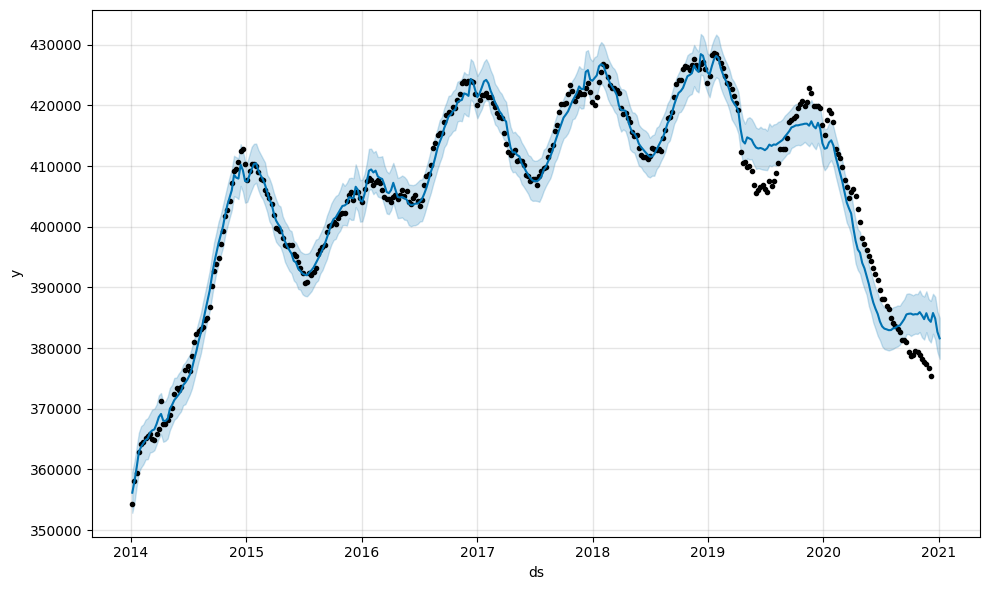

In [19]:
# Visualize the forecast
m.plot(forecast);

The future warnings included will disappear once the Prophet team updates the package to deal with newer Pandas versions

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

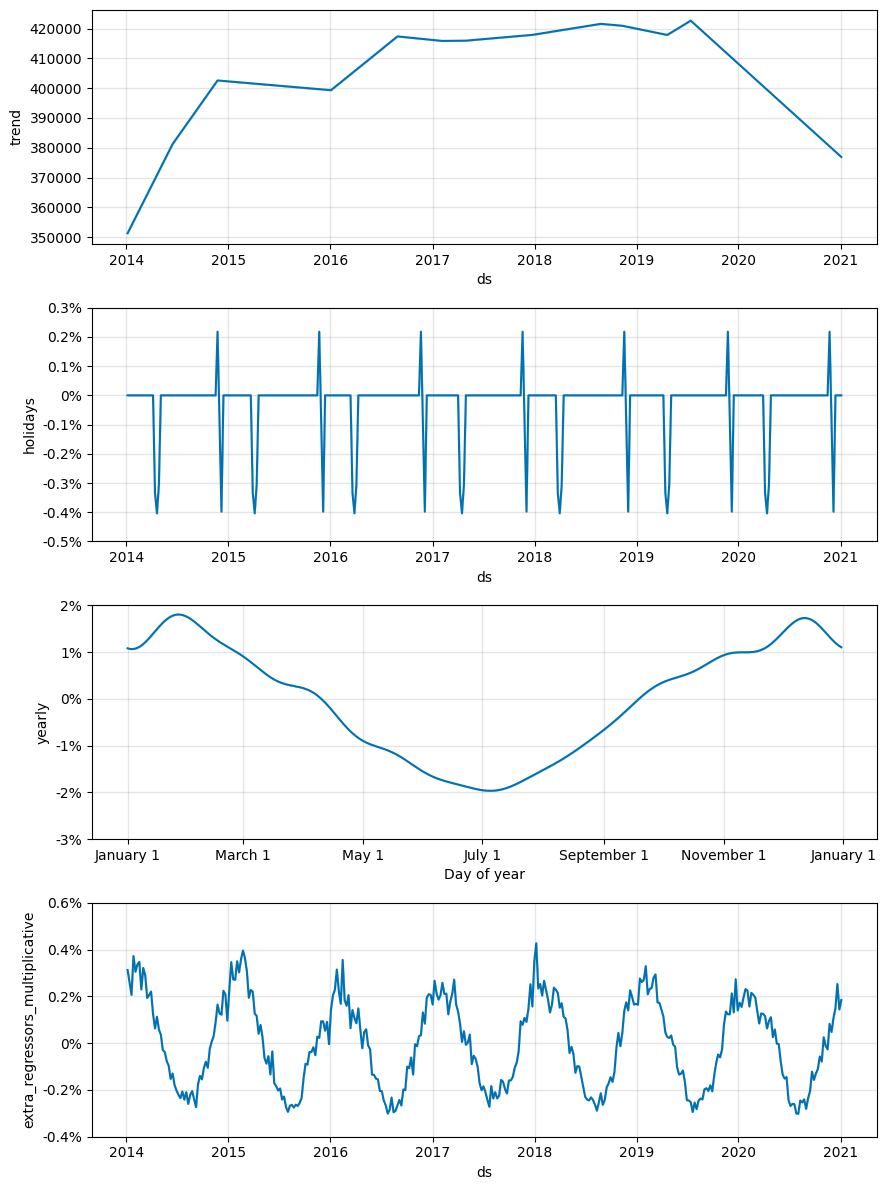

In [ ]:
# Plot the forecast components to visualize the structural time series decomposition
m.plot_components(forecast);

#Cross-Validation

In [ ]:
# See the shape - to know how many weeks of data we have
df.shape

(366, 4)

In [ ]:
# Perform cross-validation for the Prophet model
df_cv = cross_validation(m,
                         horizon="4 W",        # Forecast horizon (4 weeks or 28 days)
                         initial="300 W",      # Initial training period (300 weeks or approximately 1500 days)
                         parallel='processes')  # Use parallel processing to speed up computation

INFO:prophet:Making 29 forecasts with cutoffs between 2019-10-13 00:00:00 and 2020-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7a8c6eae29b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1j6t5hc/8vaa234v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1j6t5hc/h2bk98gw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1j6t5hc/jmgzinw7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32516', 'data', 'file=/tmp/tmpz1j6t5hc/8vaa234v.json', 'init=/tmp/tmpz1j6t5hc/jmgzinw7.json', 'output', 'file=/tmp/tmpz1j6t5hc/prophet_modelyne00pt2/prophet_model-20240808114636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1j6t5hc/zjfk61cw.json
DE

In [ ]:
# Cross-Validation output
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-10-20,419439.044995,418177.507546,420762.395705,420265,2019-10-13
1,2019-10-27,420162.439302,418801.513376,421524.815959,420670,2019-10-13
2,2019-11-03,420735.266619,419387.135009,422074.138876,419924,2019-10-13
3,2019-11-10,420927.767308,419434.659279,422333.118968,420624,2019-10-13
4,2019-11-03,420670.636519,419362.135329,422055.341775,419924,2019-10-27
...,...,...,...,...,...,...
111,2020-11-22,392501.891016,388932.475328,395951.105000,377413,2020-10-25
112,2020-11-15,389047.136088,385472.627242,392419.744600,377700,2020-11-08
113,2020-11-22,390548.584990,387046.358311,394017.719075,377413,2020-11-08
114,2020-11-29,389605.894175,386148.908050,392706.448950,376769,2020-11-08


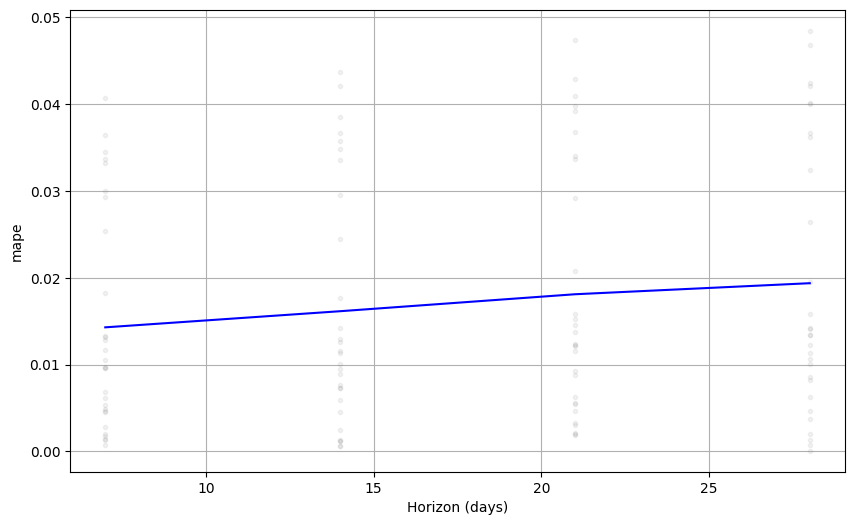

In [ ]:
# Plot the cross-validation metric (RMSE) for the Prophet model
plot_cross_validation_metric(df_cv, metric = "mape");

#Parameter Tuning

In [ ]:
# Define a grid of parameters for hyperparameter tuning
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],    # Mode of seasonality
              'seasonality_prior_scale': [5, 10, 20],                # Prior scale for seasonality
              'holidays_prior_scale': [5, 10, 20],                   # Prior scale for holidays
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}          # Prior scale for changepoints

# Generate all possible combinations of the parameters
grid = ParameterGrid(param_grid)

# Count the total number of parameter combinations in the grid
len(list(grid))


54

In [ ]:
# List to store RMSE results for each parameter combination
rmse = []

# Loop through each parameter combination in the grid
for params in grid:
    # Build and configure the Prophet model with the current parameter combination
    m = Prophet(growth='linear',                        # Use a linear growth trend
                yearly_seasonality=True,                # Enable yearly seasonality component
                weekly_seasonality=False,               # Disable weekly seasonality component
                holidays=holidays,                      # Include holiday effects
                seasonality_mode=params['seasonality_mode'],  # Set seasonality mode
                seasonality_prior_scale=params['seasonality_prior_scale'],  # Set prior scale for seasonality
                holidays_prior_scale=params['holidays_prior_scale'],  # Set prior scale for holidays
                changepoint_prior_scale=params['changepoint_prior_scale'])  # Set prior scale for changepoints

    # Add custom regressors to the model
    m.add_regressor('Christmas')
    m.add_regressor('Temperature')

    # Fit the model to the training data
    m.fit(training)

    # Perform cross-validation
    df_cv = cross_validation(m,
                             horizon="4 W",         # Forecast horizon (4 weeks or 28 days)
                             initial="300 W",       # Initial training period (300 weeks or approximately 1500 days)
                             parallel='processes') # Use parallel processing

    # Measure the performance (RMSE) and store the result
    error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
    rmse.append(error)


Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] start processing
11:57:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
11:57:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1j6t5hc/bobme49z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1j6t5hc/69s1sbdl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82336', 'data', 'file=/tmp/tmpz1j6t5hc/bobme49z.json', 'init=/tmp/tmpz1j6t5hc/69s1sbdl.json', 'output', 'file=/tmp/tmpz1j6t5hc/prophet_modelgmfbihiv/prophet_model-20240808115741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:57:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz1j6t5hc/hvk

In [ ]:
#get the best parameters
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.01,5,additive,5,9113.229106
1,0.01,5,additive,10,9101.021510
2,0.01,5,additive,20,9065.225899
3,0.01,5,multiplicative,5,8963.429121
4,0.01,5,multiplicative,10,8990.670392
5,0.01,5,multiplicative,20,8980.391045
6,0.01,10,additive,5,9058.241491
7,0.01,10,additive,10,9092.521379
8,0.01,10,additive,20,9087.409843
9,0.01,10,multiplicative,5,8974.821684
